<a href="https://colab.research.google.com/github/kristellu/mental_illness_pipeline/blob/master/mental_illness_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Application of Natural Language Processing and Deep Learning Models for the Detection of Mental Health Disorders in Social Networks.**

 *Kristell Urueta and José Márquez are with the Systems Engineering and Computer Science Department, Universidad del Norte, Barranquilla, CO 018000 Colombia, (e-mail:kristellu@uninorte.edu.co, jmarquez@uninorte.edu.co).*

**Abstract**— This study shows the use of Artificial Intelligence (AI) techniques and advanced trained models to analyze emotions expressed in social network texts, focusing on their relationship with mental health disorders. Using the NLTK library and algorithms such as VADER in Python, a natural language processing model is implemented to classify messages into specific emotional categories: positive, negative and neutral. Messages classified as negative are filtered for a more detailed study of the concerns and adverse emotions expressed. Additionally, the Latent Dirichlet Allocation (LDA) model is employed for thematic segmentation of the data, identifying patterns and themes prevalent in negative messages. This combined methodology provides a comprehensive understanding of the emotions and concerns manifested in the texts, facilitating the inference of possible underlying mental states. To enrich the analysis, it integrates with OpenAI's GPT-3.5 and GPT-4.0 API, offering advanced and contextualized interpretations of the connection between identified themes and associated emotions. This approach presents itself as a valuable tool for psychology and psychiatry, particularly for monitoring and analyzing mental health indicators in digital communications.

***Index Terms***— Bidirectional Encoder Representations from Transformers (BERT), Latent Dirichlet Allocation (LDA), TF-IDF, Natural Language Processing (NLP), Topic Modeling, VADER Sentiment Analysis.

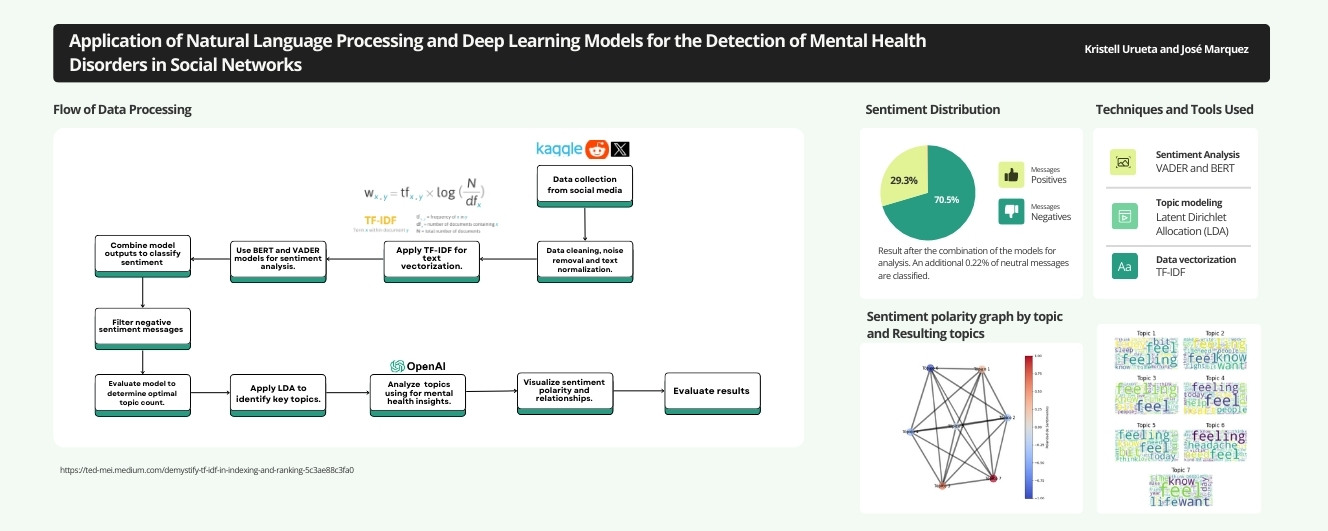

# Dependencies

In [ ]:
!pip install pandas nltk scikit-learn matplotlib seaborn xlrd openpyxl
!pip install cohere tiktoken gensim openai
!pip install transformers
!pip install torch
!pip install vaderSentiment
!pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.8/207.8 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.9/362.9 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 9.1 MB/s eta 0:00:00


# Loading the dataset

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Maestria2024/TESIS_AVANCES/paper

/content/drive/MyDrive/Maestria2024/TESIS_AVANCES/paper


# Sentiment analysis of the received dataset

We clean the received dataset and use NLP for the segmentation of the received data and return the file categorized by emotions.

This script performs the following tasks:


*   Cleans and prepares the tweets for analysis.

*   Utilizes both BERT (through Hugging Face's pipeline) and VADER for sentiment analysis.

* Combines the outputs from both models to determine the final sentiment label, focusing on a neutral classification when both models agree on neutrality, adjusted for VADER's threshold.


In [ ]:
import pandas as pd
import torch
from transformers import DistilBertTokenizer, pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk import download
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt

# Download stopwords from NLTK
download('stopwords')
download('punkt')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Clean and prepare the message
def clean_message(text):
    if text is None or text != text:
        return ''
    text = str(text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Eliminar stopwords
    return text

In [ ]:
def truncate_message(text, tokenizer):
    # Encode the text, truncate it to the maximum length the model can handle, and return the truncated string
    # 'max_length' is set to 512 because it is the maximum length that models like BERT can handle
    encoded = tokenizer.encode(text, add_special_tokens=True, max_length=512, truncation=True)
    return tokenizer.decode(encoded)

In [ ]:
# Read the Excel file
df = pd.read_excel("dataset_eng.xlsx", usecols=[0], header=None)
df.columns = ['message']
print(f"Total number of elements in the initial dataset: {len(df)}")

# Apply the cleaning function to the 'message' column
df['clear_message'] = df['message'].apply(clean_message)

# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load tokenizer and model specifically fine-tuned for sentiment analysis
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", device=device, tokenizer=tokenizer, truncation=True)

# Perform sentiment analysis with BERT
df['bert_sentiments'] = df['clear_message'].apply(lambda x: sentiment_pipeline(x)[0])

# Instantiate and use VADER
analyzer = SentimentIntensityAnalyzer()
df['vader_sentiments'] = df['clear_message'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Normalize VADER scores to match BERT score scale (0 to 1)
df['vader_normalized'] = (df['vader_sentiments'] + 1) / 2

# Get BERT scores normalized (already between 0 and 1)
df['bert_scores'] = df['bert_sentiments'].apply(lambda x: x['score'] if x['label'].lower() == 'positive' else -x['score'])
df['bert_normalized'] = (df['bert_scores'] + 1) / 2

# Combine scores with a weighted average
weight_bert = 0.7
weight_vader = 0.3
df['combined_score'] = df['bert_normalized'] * weight_bert + df['vader_normalized'] * weight_vader

# Determine final sentiment from combined scores
def combined_label(score):
    if score > 0.6:
        return 'positive'
    elif score < 0.4:
        return 'negative'
    else:
        return 'neutral'

df['final_sentiment'] = df['combined_score'].apply(combined_label)

Total number of elements in the initial dataset: 23731


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



#### **Sentiment Distribution Chart**
This chart seeks to show the number of initial messages classified in each sentiment category (positive, negative, neutral).

 A high proportion of negative messages may indicate a prevalence of concerns or negative emotional states in the data analyzed. This information can be crucial to identify worrying emotional patterns in the context studied.


,Sentiment,Quantity,Percentage
0,negative,16718,70.447937
1,positive,6960,29.328726
2,neutral,53,0.223337
0,Total,23731,100.000000


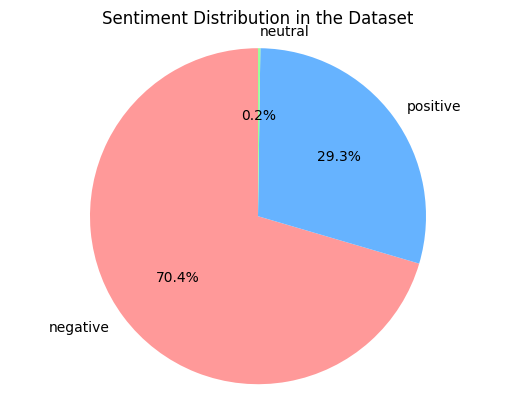

File result_categorized.xlsx saved!


In [ ]:
# Create a summary table with quantity, percentage, and total
sentiment_summary = df['final_sentiment'].value_counts().reset_index()
sentiment_summary.columns = ['Sentiment', 'Quantity']
sentiment_summary['Percentage'] = 100 * sentiment_summary['Quantity'] / sentiment_summary['Quantity'].sum()
total_row = pd.DataFrame([['Total', sentiment_summary['Quantity'].sum(), 100.0]], columns=['Sentiment', 'Quantity', 'Percentage'])
sentiment_summary = pd.concat([sentiment_summary, total_row])

# Display the summary table
display(sentiment_summary)

# Visualization of the sentiment distribution
labels = df['final_sentiment'].value_counts().index
sizes = df['final_sentiment'].value_counts().values

# Calculate percentages
sizes = 100 * sizes / sizes.sum()

# Create pie chart
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff', '#99ff99'])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Title of the chart
print("")
plt.title('Sentiment Distribution in the Dataset')

# Show the chart
plt.show()

# Save to Excel
file_name = 'result_categorized.xlsx'
df[['message', 'final_sentiment']].to_excel(file_name, index=False, engine='openpyxl')
print(f"File {file_name} saved!")

# Topic Modeling

Generating topics from a dataset, especially focusing on negative sentiments, can provide valuable insights into the underlying issues or concerns. The process typically involves the following steps

* Filter for Negative Sentiments: Extract only the negative sentiment messages.
* Vectorize the Text: Use TF-IDF vectorization.
* Apply LDA: Use LDA for topic modeling.


In [ ]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import download
from collections import Counter
import gensim
from gensim.models import CoherenceModel
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import networkx as nx

df = pd.read_excel("result_categorized.xlsx")
display(df)

,message,final_sentiment
0,i didnt feel humiliated,positive
1,i can go from feeling so hopeless to so damned...,negative
2,im grabbing a minute to post i feel greedy wrong,negative
3,i am ever feeling nostalgic about the fireplac...,positive
4,i am feeling grouchy,negative
...,...,...
23726,is that snow,positive
23727,moulin rouge mad me cry once again,negative
23728,trying to shout but can t find people on the list,negative
23729,ughh can t find my red sox hat got ta wear thi...,negative


In [ ]:
# Filtrar mensajes con sentimiento negativo
negative_df = df[df['final_sentiment'] == 'negative'].copy()

# Descargar recursos necesarios de nltk
download('stopwords')
download('punkt')

# Tokenización y eliminación de stopwords
stop_words = set(stopwords.words('english'))
negative_df['processed_message'] = negative_df['message'].apply(lambda x: ' '.join([word for word in word_tokenize(x.lower()) if word.isalpha() and word not in stop_words]))

# Vectorización de texto usando TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(negative_df['processed_message'])

# Función para mostrar tópicos
def display_topics(model, feature_names, no_top_words=10):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        topics.append(top_words)
        print(f"Tópico {topic_idx + 1}:")
        print(top_words)
    return topics

# Función para calcular la coherencia de los tópicos
def compute_coherence_values(tfidf, texts, dictionary, k):
    lda_model = LatentDirichletAllocation(n_components=k, random_state=42)
    lda_model.fit(tfidf)
    topics = lda_model.components_
    coherence_model_lda = CoherenceModel(
        topics=[[dictionary[i] for i in topic.argsort()[:-10 - 1:-1]] for topic in topics],
        texts=texts, dictionary=dictionary, coherence='c_v'
    )
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

# Convertir mensajes en formato adecuado para el cálculo de coherencia
texts = [text.split() for text in negative_df['processed_message']]
id2word = gensim.corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

# Calcular puntajes de coherencia para diferentes números de tópicos
coherence_scores = []
for num_topics in range(2, 11):
    coherence_score = compute_coherence_values(tfidf, texts, id2word, num_topics)
    coherence_scores.append((num_topics, coherence_score))
    print(f"Número de Tópicos: {num_topics}, Coherencia: {coherence_score}")

# Seleccionar el número óptimo de tópicos
optimal_num_topics = max(coherence_scores, key=lambda x: x[1])[0]
print(f"Número óptimo de tópicos: {optimal_num_topics}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Número de Tópicos: 2, Coherencia: 0.45545828914247777
Número de Tópicos: 3, Coherencia: 0.4383219708317945
Número de Tópicos: 4, Coherencia: 0.45313814161559673
Número de Tópicos: 5, Coherencia: 0.42856569125551075
Número de Tópicos: 6, Coherencia: 0.4571446681487053
Número de Tópicos: 7, Coherencia: 0.4575637043924961
Número de Tópicos: 8, Coherencia: 0.45678060465459663
Número de Tópicos: 9, Coherencia: 0.4317573637994644
Número de Tópicos: 10, Coherencia: 0.4418814250008859
Número óptimo de tópicos: 7


In [ ]:
lda_model = LatentDirichletAllocation(n_components=optimal_num_topics, random_state=42)
lda_model.fit(tfidf)

# Crear DataFrame para los temas
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Formatear los temas y palabras clave
topics_data = []
for idx, topic in enumerate(lda_model.components_):
    topic_words = [tfidf_feature_names[i] for i in topic.argsort()[:-len(topic) - 1:-1]]
    topic_str = ' '.join(topic_words)
    topics_data.append({"Topic": f"Topic {idx + 1}", "Words": topic_str})

topics_df = pd.DataFrame(topics_data)
display(topics_df)

# Guardar temas en Excel
topics_df.to_excel("result_topics_negative.xlsx", index=False)

print("Los tópicos han sido guardados en 'result_topics_negative.xlsx'.")

,Topic,Words
0,Topic 1,feel feeling im like little punished today dis...
1,Topic 2,feel feeling like im things awkward regretful ...
2,Topic 3,feel feeling im like really dont sad ive know ...
3,Topic 4,depression feel feeling cold anxiety like thee...
4,Topic 5,feel feeling im like agitated stressed little ...
5,Topic 6,http feel href depression com feeling heartbro...
6,Topic 7,feel like wa want life know time day people re...


Los tópicos han sido guardados en 'result_topics_negative.xlsx'.


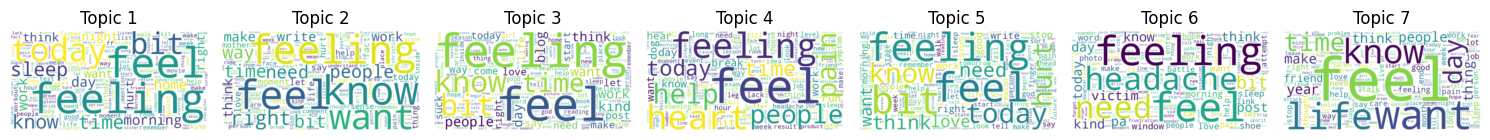

In [ ]:
# Generar nubes de palabras para cada tópico
fig, axes = plt.subplots(1, optimal_num_topics, figsize=(15, 5), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    topic_words = topics_data[i]['Words']
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(topic_words)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"Topic {i + 1}")
plt.tight_layout()
plt.show()

In [ ]:
results_df = pd.DataFrame(columns=['Topic', 'Query'] + models)

<ipython-input-32-22ab32e33d07>:35: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Polaridad de Sentimientos")


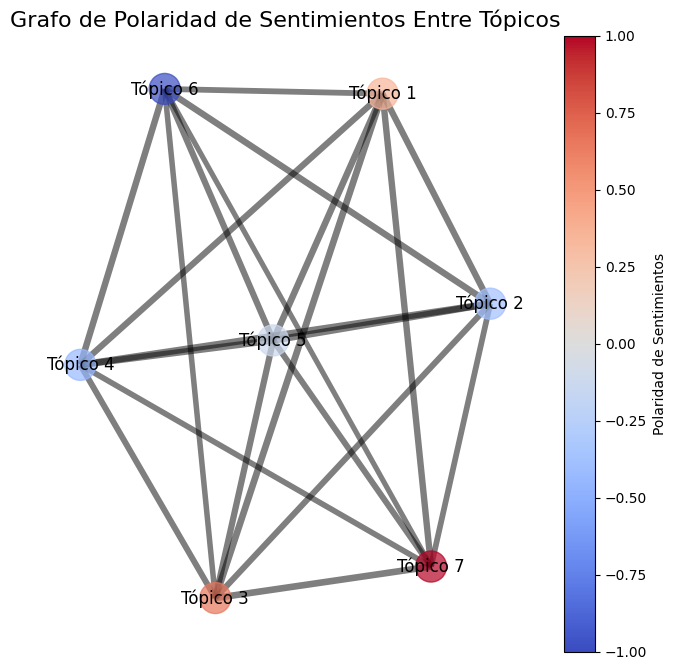

In [ ]:
import numpy as np

# Análisis de Sentimientos con VADER
analyzer = SentimentIntensityAnalyzer()

# Crear un grafo donde cada nodo es un tópico y los enlaces representan la similitud en polaridad
G = nx.Graph()

# Añadir nodos al grafo (cada nodo representa un tópico)
for i, topic in enumerate(topics):
    # Calcular la polaridad promedio de las palabras dentro de cada tópico
    avg_sentiment = np.mean([analyzer.polarity_scores(word)['compound'] for word in topic])
    G.add_node(i, sentiment=avg_sentiment, label=f"Tópico {i + 1}")

# Añadir enlaces entre tópicos basados en la similitud de polaridad
for i in range(len(topics)):
    for j in range(i + 1, len(topics)):
        sentiment_i = G.nodes[i]['sentiment']
        sentiment_j = G.nodes[j]['sentiment']
        # La similitud puede ser la inversa de la diferencia absoluta de las polaridades
        similarity = 1 - abs(sentiment_i - sentiment_j)
        G.add_edge(i, j, weight=similarity)

# Visualización del grafo de polaridad entre tópicos
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G, seed=42)
node_colors = [G.nodes[node]['sentiment'] for node in G]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.coolwarm, node_size=500, alpha=0.7)
nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight']*5 for u, v in G.edges], alpha=0.5)
nx.draw_networkx_labels(G, pos, labels={node: G.nodes[node]['label'] for node in G}, font_size=12, font_color='black')

plt.title("Grafo de Polaridad de Sentimientos Entre Tópicos", fontsize=16)
sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
plt.colorbar(sm, label="Polaridad de Sentimientos")
plt.axis('off')
plt.show()

Nodos Representan Tópicos: Cada nodo en el grafo representa un tópico identificado mediante LDA. La polaridad promedio de las palabras en cada tópico determina el color del nodo.

Enlaces Basados en Similitud de Polaridad: Los enlaces entre los nodos representan la similitud de polaridad entre los tópicos. La similitud se calcula como la inversa de la diferencia absoluta de las polaridades promedio de los tópicos. Cuanto más similar sea la polaridad, más fuerte será el enlace entre los tópicos.


# Analysis and mental diagnosis of topical issues

Already having the information filtered and consolidated by topics, we proceed to make the diagnosis of possible mental illnesses detected in each one of them.


In [ ]:
import os
import re
import pandas as pd
from openai import OpenAI
from google.colab import auth
from getpass import getpass

# Prompt the user to input the API key securely
api_key = getpass('Enter your OpenAI API key: ')

# Initialize the OpenAI client with the API key
client = OpenAI(api_key=api_key)

Enter your OpenAI API key: ··········


In [ ]:
# Modelos a compare
models = ["gpt-3.5-turbo-0125", "gpt-4"]
# Función para seleccionar las palabras más representativas de un tópico
def get_representative_words(topic_words, top_n=5):
    # Seleccionar las top_n palabras más importantes
    return " ".join(topic_words[:top_n])

# Iterar sobre cada tema en el DataFrame
for idx, row in topics_df.iterrows():
    # Usar las palabras más representativas en lugar de solo las primeras 5
    topic_words = row["Words"].split()  # Palabras ya ordenadas por importancia
    query = get_representative_words(topic_words, top_n=5)

    # Crear una fila para los resultados
    result_row = {'Topic': row['Topic'], 'Query': query}

    # Obtener respuestas de cada modelo
    for model in models:
        try:
            response = openai.ChatCompletion.create(
                model=model,
                messages=[
                    {"role": "system", "content": "Diagnosis of psychological conditions or mental illnesses based on a set of given topical words. Provide a general diagnosis suitable for a report, without segmenting by context."},
                    {"role": "user", "content": query}
                ],
                temperature=0  # Mantener la temperatura en 0 para resultados consistentes
            )

            # Almacenar la respuesta en el DataFrame
            result_row[model] = response['choices'][0]['message']['content'].strip()
        except Exception as e:
            print(f"An error occurred with model {model} for topic {idx}: {e}")
            result_row[model] = 'Error occurred during API call'

    # Agregar la fila al DataFrame de resultados
    results_df = pd.concat([results_df, pd.DataFrame([result_row])], ignore_index=True)

# Guardar los resultados en un archivo CSV
results_df.to_csv("result_topic_analysis.csv", index=False)
display(results_df)

print("Responses have been saved in result_topic_analysis.csv")

,Topic,Query,gpt-3.5-turbo-0125,gpt-4
0,Topic 1,,"Based on the given topical words, it appears t...","1. Anxiety, Panic, Fear, Worry, Stress: These ..."
1,Topic 2,,"Based on the given topical words, it appears t...",1. Anxiety\n2. Depression\n3. Obsessive-Compul...
2,Topic 3,,"Based on the given topical words, it appears t...","1. Anxiety, Panic, Fear, Worry, Stress: These ..."
3,Topic 4,,"Based on the given topical words, it appears t...","Obsessive-Compulsive Disorder, Anxiety, Depres..."
4,Topic 5,,"Based on the given topical words, it appears t...","Apologies, but you haven't provided any topica..."
5,Topic 6,,"Based on the given topical words, it appears t...","1. Anxiety, Panic, Fear, Worry, Stress: These ..."
6,Topic 7,,"Based on the given topical words, it appears t...",You didn't provide any topical words. Please p...


Responses have been saved in result_topic_analysis.csv
